> __Paper:__
Physics-informed neural networks: A deep learning framework for solving forward and
inverse problems involving nonlinear partial differential equations

> [Link](https://doi.org/10.1016/j.jcp.2018.10.045)

> In This notebook, we add noise to the observed data. To do that, first we increase the minimum feasible number of observed datapoints by ten folds. The lower bound is found in the onther [notebook](PINN_Turring_ASDM_random_samples_sparse.ipynb) that is four data points per time steps in a $32 \times 32$ grid.

> So, we randomly sample $T \times 4 = 512 \times 4 \times 2 = 496$ grid points of a solution of the ASDM for a $32 \times 32$ grid, integerated for 0 to 50000 for $T = 512$ time steps. Note that the $T \times 4$ is the lower bound, which we increased by ten folds.

> Next, we sample from a normal distibution $\epsilon_{s,a} \sim \mathcal{N}(0, \sigma)$ such that

<h3><center>$a_{o} = a_{ex} + \epsilon_{a}$</center></h3>

> and

<h3><center>$s_{o} = s_{ex} + \epsilon_{s}$</center></h3>

> where $a_{o}$ and $a_{s}$ are observed values for training, and $a_{ex}$ and $s_{ex}$ are the exact solution of the PDE. The goal here is finding a relation between ten fold increase and $\sigma$. Or in a general setting, if we increase the data set size by $m$ fold and simply assuming a linear relation between the fold number and $\sigma$, we would like to find $\sigma = \lambda m$, or the porpotionality coefficient.

> The free parameters of the model are fixed.

> We also randomly select $T \times 32 \times 2 = 512 \times 32 \times 2 = 32768$ points in $(x,t,y)$ space and define a second PDE loss function over them. These are points that there is no observed value corresponds to them.


In [1]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../clones/PINNs/Utilities/')
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
#from pyDOE import lhs
from mpl_toolkits.mplot3d import Axes3D
import time
import matplotlib.gridspec as gridspec
from mpl_toolkits.axes_grid1 import make_axes_locatable


import os
#os.environ["CUDA_VISIBLE_DEVICES"]="0,1"
#os.environ["CUDA_VISIBLE_DEVICES"]="0"
#os.environ["CUDA_VISIBLE_DEVICES"]="1"
#os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

#tf.logging.set_verbosity(tf.logging.ERROR)

/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/anaconda3/envs/tensorflow.1.12/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/anaconda3/envs

In [2]:
np.random.seed(1234)
tf.set_random_seed(1234)


class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, x, y, t, a, s,
                 X_f, Y_f, T_f, layers): 
        
        with tf.device('gpu:0'):
        #with tf.device('cpu:0'):
                 
            X = np.concatenate([x, y, t], 1)

            self.lb = X.min(0)
            self.ub = X.max(0)                        

            self.x = X[:,0:1]
            self.y = X[:,1:2]
            self.t = X[:,2:3]

            self.a = a
            self.s = s
            
            self.X_f = X_f
            self.Y_f = Y_f
            self.T_f = T_f
                        
            self.layers = layers

            # Initialize NN
            self.weights, self.biases = self.initialize_NN(layers)        

            # Initialize parameters
            self.D_a = tf.constant(0.005, dtype=tf.float32)#tf.Variable([0.005], dtype=tf.float32)
            self.D_s = tf.constant(0.2, dtype=tf.float32)#tf.Variable([0.2], dtype=tf.float32)
            self.sigma_a = tf.constant(0.0, dtype=tf.float32)#tf.Variable([0.0], dtype=tf.float32)
            self.sigma_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.mu_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_a = tf.constant(0.01, dtype=tf.float32)#tf.Variable([0.01], dtype=tf.float32)
            self.rho_s = tf.constant(0.02, dtype=tf.float32)#tf.Variable([0.02], dtype=tf.float32)
            self.kappa_a = tf.constant(0.25, dtype=tf.float32)#tf.Variable([0.25], dtype=tf.float32)

            # tf placeholders and graph
            self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                         log_device_placement=True))

            self.x_tf = tf.placeholder(tf.float32, shape=[None, self.x.shape[1]], name="x_tf")
            self.y_tf = tf.placeholder(tf.float32, shape=[None, self.y.shape[1]], name="y_tf")
            self.t_tf = tf.placeholder(tf.float32, shape=[None, self.t.shape[1]], name="t_tf")

            self.a_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_tf")
            self.s_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_tf")
            
            self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.X_f.shape[1]], name="x_f_tf")
            self.y_f_tf = tf.placeholder(tf.float32, shape=[None, self.Y_f.shape[1]], name="y_f_tf")
            self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.T_f.shape[1]], name="t_f_tf")            
            
            
            self.a_f_tf = tf.placeholder(tf.float32, shape=[None, self.a.shape[1]], name="a_f_tf")
            self.s_f_tf = tf.placeholder(tf.float32, shape=[None, self.s.shape[1]], name="s_f_tf")
                        

            self.a_pred, self.s_pred, self.f_a_pred, self.f_s_pred = self.net_ASDM(self.x_tf, self.y_tf, self.t_tf)
            
            _, _, self.a_f_tf, self.s_f_tf = self.net_ASDM(self.x_f_tf, self.y_f_tf, self.t_f_tf)
            
            _, _, self.a_f_tf, self.s_f_tf = self.net_ASDM(self.x_f_tf, self.y_f_tf, self.t_f_tf)

            self.loss_1 = tf.reduce_sum(tf.square(self.a_tf - self.a_pred)) + \
                        tf.reduce_sum(tf.square(self.s_tf - self.s_pred)) 

            self.loss_a = tf.reduce_sum(tf.square(self.f_a_pred), name = "loss_a")

            self.loss_s = tf.reduce_sum(tf.square(self.f_s_pred), name = "loss_s")
            
            self.loss_a_f = tf.reduce_sum(tf.square(self.a_f_tf), name = "loss_a_f")
            
            self.loss_s_f = tf.reduce_sum(tf.square(self.s_f_tf), name = "loss_s_f")

            self.loss = self.loss_1 + self.loss_a + self.loss_s + self.loss_a_f + self.loss_s_f       

            self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                    method = 'L-BFGS-B', 
                                                                    options = {'maxiter': 50000,
                                                                               'maxfun': 50000,
                                                                               'maxcor': 50,
                                                                               'maxls': 50,
                                                                               'ftol' : 1.0 * np.finfo(float).eps})        

            self.optimizer_Adam = tf.train.AdamOptimizer()
            self.train_op_Adam = self.optimizer_Adam.minimize(self.loss)                    

            init = tf.global_variables_initializer()
            self.sess.run(init)

    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32)
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))
            #H = tf.nn.relu(tf.add(tf.matmul(H, W), b))
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
        
    def net_ASDM(self, x, y, t):
        D_a = self.D_a
        D_s = self.D_s
        sigma_a = self.sigma_a
        sigma_s = self.sigma_s
        mu_a = self.mu_a
        rho_a = self.rho_a
        rho_s = self.rho_s
        kappa_a = self.kappa_a
        
        a_and_s = self.neural_net(tf.concat([x,y,t], 1), self.weights, self.biases)
        #a = a_and_s[:,0:1]
        a = tf.slice(a_and_s, [0,0], [-1,1], name = "a_pred")
        #s = a_and_s[:,1:2]                
        s = tf.slice(a_and_s, [0,1], [-1,1], name = "s_pred")
        
        a_t = tf.gradients(a, t)[0]
        a_x = tf.gradients(a, x)[0]
        a_y = tf.gradients(a, y)[0]
        a_xx = tf.gradients(a_x, x)[0]
        a_yy = tf.gradients(a_y, y)[0]
        
        s_t = tf.gradients(s, t)[0]
        s_x = tf.gradients(s, x)[0]
        s_y = tf.gradients(s, y)[0]
        s_xx = tf.gradients(s_x, x)[0]
        s_yy = tf.gradients(s_y, y)[0]
        
        f = a*a*s/(1 + kappa_a*a*a)
        f_a = a_t - D_a*(a_xx + a_yy) - rho_a*f + mu_a*a - sigma_a
        f_s = s_t - D_s*(s_xx + s_yy) + rho_s*f - sigma_s
        
        return a, s, f_a, f_s
    
    def callback(self, loss, D_a, D_s, sigma_a,sigma_s,
                       rho_a, rho_s, mu_a, kappa_a):
        print(f"loss: {loss},\n"
              f"D_a: {D_a:.4f}, D_s: {D_s:.4f}\n"
              f"sigma_a: {sigma_a:.4f}, sigma_s: {sigma_s:.4f}\n"
              f"rho_a: {rho_a:.4f}, rho_s: {rho_s:.4f}\n"
              f"mu_a: {mu_a:.4f}, kappa_a: {kappa_a:.4f}\n")
        
      
    def train(self, nIter, early_stop_thresh = None): 

        tf_dict = {self.x_tf: self.x, self.y_tf: self.y, self.t_tf: self.t,
                   self.a_tf: self.a, self.s_tf: self.s,
                   self.x_f_tf: self.X_f, self.y_f_tf: self.Y_f, self.t_f_tf: self.T_f}
        
        start_time = time.time()
        for it in range(nIter):
            self.sess.run(self.train_op_Adam, tf_dict)
            
            loss_value = self.sess.run(self.loss, tf_dict)
            # Print
            if it % 100 == 0:
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                loss_a_f_value = self.sess.run(self.loss_a_f, tf_dict)
                loss_s_f_value = self.sess.run(self.loss_s_f, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"          loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      f"          loss_a_f: {loss_a_f_value:.8f}, loss_s_f: {loss_s_f_value:.8f}\n"
                      f"          loss_a_f/N: {loss_a_f_value/N:.8f}, loss_s_f/N: {loss_s_f_value/N:.8f}\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                
            if early_stop_thresh is not None and early_stop_thresh >= loss_value:
                print("#"*50)
                print("         Early stop")
                print("#"*50)
                elapsed = time.time() - start_time
                loss_a_value = self.sess.run(self.loss_a, tf_dict)
                loss_s_value = self.sess.run(self.loss_s, tf_dict)
                loss_a_f_value = self.sess.run(self.loss_a_f, tf_dict)
                loss_s_f_value = self.sess.run(self.loss_s_f, tf_dict)
                #loss_value = self.sess.run(self.loss, tf_dict)
                D_a_value = self.sess.run(self.D_a)#[0]
                D_s_value = self.sess.run(self.D_s)#[0]
                sigma_a_value = self.sess.run(self.sigma_a)#[0]
                sigma_s_value = self.sess.run(self.sigma_s)#[0]
                rho_a_value = self.sess.run(self.rho_a)#[0]
                rho_s_value = self.sess.run(self.rho_s)#[0]
                mu_a_value = self.sess.run(self.mu_a)#[0]
                kappa_a_value = self.sess.run(self.kappa_a)#[0]
                
                N = self.x.shape[0]
                print(f"It: {it}, loss_a  : {loss_a_value:.8f}, loss_s  : {loss_s_value:.8f}, loss  : {loss_value:.2f},\n"
                      f"          loss_a/N: {loss_a_value/N:.8f}, loss_s/N: {loss_s_value/N:.8f}, loss/N: {loss_value/N:.8f},\n"
                      f"          loss_a_f: {loss_a_f_value:.8f}, loss_s_f: {loss_s_f_value:.8f}\n"
                      f"          loss_a_f/N: {loss_a_f_value/N:.8f}, loss_s_f/N: {loss_s_f_value/N:.8f}\n"
                      #f"D_a: {D_a_value:.4f}, D_s: {D_s_value:.4f}\n"
                      #f"sigma_a: {sigma_a_value:.4f}, sigma_s: {sigma_s_value:.4f}\n"
                      #f"rho_a: {rho_a_value:.4f}, rho_s: {rho_s_value:.4f}\n"
                      #f"mu_a: {mu_a_value:.4f}, kappa_a: {kappa_a_value:.4f}, \n"
                      f"Time:{elapsed:.2f}\n")
                start_time = time.time()
                break
                
            
        #self.optimizer.minimize(self.sess,
        #                        feed_dict = tf_dict,
        #                        fetches = [self.loss, self.D_a, self.D_s,
        #                                  self.sigma_a, self.sigma_s,
        #                                  self.rho_a, self.rho_s,
        #                                  self.mu_a, self.kappa_a],
        #                        loss_callback = self.callback)
            
    
    def predict(self, x_star, y_star, t_star):
        
        tf_dict = {self.x_tf: x_star, self.y_tf: y_star, self.t_tf: t_star}
        
        a_star = self.sess.run(self.a_pred, tf_dict)
        s_star = self.sess.run(self.s_pred, tf_dict)
        
        return a_star, s_star

In [26]:
#layers = [3, 20, 20, 20, 20, 20, 20, 20, 20, 2]
layers = [3, 64, 64, 64, 64, 2]
#layers = [3, 128, 128, 128, 128, 2]

#layers = [3, 100, 100, 100, 100, 2]

# Load Data
import os
data_path = os.path.abspath("turing.npy")
with open(data_path, 'rb') as f:
    data = np.load(f)
    
data_path = os.path.abspath("turing_t.npy")
with open(data_path, 'rb') as f:
    t_star = np.load(f) 
    
T = t_star.shape[0]    
    
L = 50
x_size = data.shape[1]
y_size = data.shape[2]
N = x_size*y_size
x = L*np.linspace(0,1,x_size)
y = L*np.linspace(0,1,y_size)

X,Y = np.meshgrid(x, y, sparse=False, indexing='ij')
XX = np.tile(X.flatten(), T) # N x T
YY = np.tile(Y.flatten(), T) # N x T
TT = np.repeat(t_star[-T:], N) # T x N

AA = np.einsum('ijk->kij', data[0, :, :, -T:]).flatten() # N x T
SS = np.einsum('ijk->kij', data[1, :, :, -T:]).flatten() # N x T


x = XX[:, np.newaxis] # NT x 1
y = YY[:, np.newaxis] # NT x 1
t = TT[:, np.newaxis] # NT x 1

a = AA[:, np.newaxis] # NT x 1
s = SS[:, np.newaxis] # NT x 1

######################################################################
######################## Noisy Data ###############################
######################################################################
# Training Data    
#idx = np.random.choice(N*T, N_train, replace=False)
signal_amp_a = (np.max(AA)-np.min(AA))/2.0
signal_amp_s = (np.max(SS)-np.min(SS))/2.0

signal_to_noise = .15
sigma_a =  signal_amp_a*signal_to_noise
sigma_s =  signal_amp_s*signal_to_noise

n_fold = 2
n_bound = 4

idx = np.random.choice(N*T, T*n_fold*n_bound, replace=False)
#idx = list(range(N*T))
x_train = x[idx,:] 
y_train = y[idx,:]
t_train = t[idx,:]
a_train = a[idx,:] + sigma_a * np.random.randn(len(idx), a.shape[1])
s_train = s[idx,:] + sigma_s * np.random.randn(len(idx), s.shape[1])


idx2 = np.random.choice(N*T, T*32*2, replace=False)
x_f_train = x[idx2,:]
y_f_train = y[idx2,:]
t_f_train = t[idx2,:]



In [27]:
print(sigma_a)
print(sigma_s)

0.14226422337772868
0.04704972951821761


In [28]:
s_train.shape

(4096, 1)

In [35]:
# Training
model = PhysicsInformedNN(x_train, y_train, t_train, a_train, s_train, 
                          x_f_train, y_f_train, t_f_train, layers)
model.train(50000, early_stop_thresh=600.0)

It: 0, loss_a  : 0.00034638, loss_s  : 1.63782525, loss  : 11632.50,
          loss_a/N: 0.00000008, loss_s/N: 0.00039986, loss/N: 2.83996606,
          loss_a_f: 0.00278476, loss_s_f: 13.10257912
          loss_a_f/N: 0.00000068, loss_s_f/N: 0.00319887
Time:9.92

It: 100, loss_a  : 0.00048497, loss_s  : 0.00489005, loss  : 1175.95,
          loss_a/N: 0.00000012, loss_s/N: 0.00000119, loss/N: 0.28709638,
          loss_a_f: 0.00374265, loss_s_f: 0.03798433
          loss_a_f/N: 0.00000091, loss_s_f/N: 0.00000927
Time:112.78

It: 200, loss_a  : 0.00031866, loss_s  : 0.00368038, loss  : 1174.79,
          loss_a/N: 0.00000008, loss_s/N: 0.00000090, loss/N: 0.28681445,
          loss_a_f: 0.00246201, loss_s_f: 0.02865548
          loss_a_f/N: 0.00000060, loss_s_f/N: 0.00000700
Time:112.76

It: 300, loss_a  : 0.00029287, loss_s  : 0.00341057, loss  : 1174.09,
          loss_a/N: 0.00000007, loss_s/N: 0.00000083, loss/N: 0.28664276,
          loss_a_f: 0.00227473, loss_s_f: 0.02663120
    

It: 3100, loss_a  : 0.00074557, loss_s  : 0.03014806, loss  : 1113.63,
          loss_a/N: 0.00000018, loss_s/N: 0.00000736, loss/N: 0.27188161,
          loss_a_f: 0.00585614, loss_s_f: 0.23436764
          loss_a_f/N: 0.00000143, loss_s_f/N: 0.00005722
Time:112.79

It: 3200, loss_a  : 0.00079366, loss_s  : 0.03194438, loss  : 1107.02,
          loss_a/N: 0.00000019, loss_s/N: 0.00000780, loss/N: 0.27026942,
          loss_a_f: 0.00620279, loss_s_f: 0.24725413
          loss_a_f/N: 0.00000151, loss_s_f/N: 0.00006036
Time:112.81

It: 3300, loss_a  : 0.00081070, loss_s  : 0.03295165, loss  : 1098.94,
          loss_a/N: 0.00000020, loss_s/N: 0.00000804, loss/N: 0.26829618,
          loss_a_f: 0.00631535, loss_s_f: 0.25540158
          loss_a_f/N: 0.00000154, loss_s_f/N: 0.00006235
Time:112.99

It: 3400, loss_a  : 0.00101632, loss_s  : 0.04343912, loss  : 1083.73,
          loss_a/N: 0.00000025, loss_s/N: 0.00001061, loss/N: 0.26458248,
          loss_a_f: 0.00799355, loss_s_f: 0.3217362

In [41]:
model.train(50000, early_stop_thresh=100.0)

It: 0, loss_a  : 0.00283271, loss_s  : 0.19704865, loss  : 602.99,
          loss_a/N: 0.00000069, loss_s/N: 0.00004811, loss/N: 0.14721435,
          loss_a_f: 0.02271692, loss_s_f: 1.51896775
          loss_a_f/N: 0.00000555, loss_s_f/N: 0.00037084
Time:1.13

It: 100, loss_a  : 0.00284777, loss_s  : 0.19860131, loss  : 580.74,
          loss_a/N: 0.00000070, loss_s/N: 0.00004849, loss/N: 0.14178300,
          loss_a_f: 0.02288538, loss_s_f: 1.52353585
          loss_a_f/N: 0.00000559, loss_s_f/N: 0.00037196
Time:112.80

It: 200, loss_a  : 0.00292437, loss_s  : 0.19985856, loss  : 559.53,
          loss_a/N: 0.00000071, loss_s/N: 0.00004879, loss/N: 0.13660473,
          loss_a_f: 0.02347421, loss_s_f: 1.53400314
          loss_a_f/N: 0.00000573, loss_s_f/N: 0.00037451
Time:113.05

It: 300, loss_a  : 0.00294183, loss_s  : 0.19979909, loss  : 540.87,
          loss_a/N: 0.00000072, loss_s/N: 0.00004878, loss/N: 0.13204864,
          loss_a_f: 0.02371937, loss_s_f: 1.53274000
          

It: 3100, loss_a  : 0.00264209, loss_s  : 0.19685888, loss  : 168.45,
          loss_a/N: 0.00000065, loss_s/N: 0.00004806, loss/N: 0.04112656,
          loss_a_f: 0.02773964, loss_s_f: 1.70309389
          loss_a_f/N: 0.00000677, loss_s_f/N: 0.00041579
Time:112.93

It: 3200, loss_a  : 0.00261899, loss_s  : 0.19535375, loss  : 164.44,
          loss_a/N: 0.00000064, loss_s/N: 0.00004769, loss/N: 0.04014691,
          loss_a_f: 0.02752313, loss_s_f: 1.68854487
          loss_a_f/N: 0.00000672, loss_s_f/N: 0.00041224
Time:113.04

It: 3300, loss_a  : 0.00263514, loss_s  : 0.19310805, loss  : 160.98,
          loss_a/N: 0.00000064, loss_s/N: 0.00004715, loss/N: 0.03930219,
          loss_a_f: 0.02756079, loss_s_f: 1.66541338
          loss_a_f/N: 0.00000673, loss_s_f/N: 0.00040660
Time:113.01

It: 3400, loss_a  : 0.00258777, loss_s  : 0.19202033, loss  : 156.80,
          loss_a/N: 0.00000063, loss_s/N: 0.00004688, loss/N: 0.03828163,
          loss_a_f: 0.02713813, loss_s_f: 1.65746403
  

It: 6200, loss_a  : 0.00244009, loss_s  : 0.18127313, loss  : 117.52,
          loss_a/N: 0.00000060, loss_s/N: 0.00004426, loss/N: 0.02869083,
          loss_a_f: 0.02458967, loss_s_f: 1.42935276
          loss_a_f/N: 0.00000600, loss_s_f/N: 0.00034896
Time:112.94

It: 6300, loss_a  : 0.00229852, loss_s  : 0.17936027, loss  : 104.71,
          loss_a/N: 0.00000056, loss_s/N: 0.00004379, loss/N: 0.02556406,
          loss_a_f: 0.02317519, loss_s_f: 1.39444077
          loss_a_f/N: 0.00000566, loss_s_f/N: 0.00034044
Time:112.95

It: 6400, loss_a  : 0.00236956, loss_s  : 0.17778736, loss  : 101.60,
          loss_a/N: 0.00000058, loss_s/N: 0.00004341, loss/N: 0.02480522,
          loss_a_f: 0.02405158, loss_s_f: 1.37534571
          loss_a_f/N: 0.00000587, loss_s_f/N: 0.00033578
Time:113.09

It: 6500, loss_a  : 0.00236225, loss_s  : 0.17689371, loss  : 100.66,
          loss_a/N: 0.00000058, loss_s/N: 0.00004319, loss/N: 0.02457468,
          loss_a_f: 0.02396691, loss_s_f: 1.36594677
  

In [46]:
model.train(10000, early_stop_thresh=32.0)

It: 0, loss_a  : 0.00234921, loss_s  : 0.17620766, loss  : 99.98,
          loss_a/N: 0.00000057, loss_s/N: 0.00004302, loss/N: 0.02440960,
          loss_a_f: 0.02385428, loss_s_f: 1.36048794
          loss_a_f/N: 0.00000582, loss_s_f/N: 0.00033215
Time:1.14

It: 100, loss_a  : 0.00234205, loss_s  : 0.17535546, loss  : 99.12,
          loss_a/N: 0.00000057, loss_s/N: 0.00004281, loss/N: 0.02419809,
          loss_a_f: 0.02376960, loss_s_f: 1.35213733
          loss_a_f/N: 0.00000580, loss_s_f/N: 0.00033011
Time:112.96

It: 200, loss_a  : 0.00233029, loss_s  : 0.17410924, loss  : 98.22,
          loss_a/N: 0.00000057, loss_s/N: 0.00004251, loss/N: 0.02397965,
          loss_a_f: 0.02367608, loss_s_f: 1.34321964
          loss_a_f/N: 0.00000578, loss_s_f/N: 0.00032793
Time:112.76

It: 300, loss_a  : 0.00232922, loss_s  : 0.17286584, loss  : 97.40,
          loss_a/N: 0.00000057, loss_s/N: 0.00004220, loss/N: 0.02377982,
          loss_a_f: 0.02373554, loss_s_f: 1.33487797
          loss

It: 3100, loss_a  : 0.00203630, loss_s  : 0.13958259, loss  : 80.85,
          loss_a/N: 0.00000050, loss_s/N: 0.00003408, loss/N: 0.01973779,
          loss_a_f: 0.02188517, loss_s_f: 1.18323374
          loss_a_f/N: 0.00000534, loss_s_f/N: 0.00028888
Time:113.01

It: 3200, loss_a  : 0.00204240, loss_s  : 0.13903777, loss  : 80.41,
          loss_a/N: 0.00000050, loss_s/N: 0.00003394, loss/N: 0.01963197,
          loss_a_f: 0.02195911, loss_s_f: 1.18038297
          loss_a_f/N: 0.00000536, loss_s_f/N: 0.00028818
Time:112.91

It: 3300, loss_a  : 0.00204736, loss_s  : 0.13836731, loss  : 80.60,
          loss_a/N: 0.00000050, loss_s/N: 0.00003378, loss/N: 0.01967857,
          loss_a_f: 0.02201708, loss_s_f: 1.17914176
          loss_a_f/N: 0.00000538, loss_s_f/N: 0.00028788
Time:113.02

It: 3400, loss_a  : 0.00203734, loss_s  : 0.13806464, loss  : 79.58,
          loss_a/N: 0.00000050, loss_s/N: 0.00003371, loss/N: 0.01942960,
          loss_a_f: 0.02190454, loss_s_f: 1.17471337
      

It: 6200, loss_a  : 0.00197887, loss_s  : 0.13054748, loss  : 70.53,
          loss_a/N: 0.00000048, loss_s/N: 0.00003187, loss/N: 0.01722038,
          loss_a_f: 0.02165445, loss_s_f: 1.13410032
          loss_a_f/N: 0.00000529, loss_s_f/N: 0.00027688
Time:112.94

It: 6300, loss_a  : 0.00196427, loss_s  : 0.13027817, loss  : 70.92,
          loss_a/N: 0.00000048, loss_s/N: 0.00003181, loss/N: 0.01731549,
          loss_a_f: 0.02145923, loss_s_f: 1.13552928
          loss_a_f/N: 0.00000524, loss_s_f/N: 0.00027723
Time:112.90

It: 6400, loss_a  : 0.00197333, loss_s  : 0.13013880, loss  : 70.02,
          loss_a/N: 0.00000048, loss_s/N: 0.00003177, loss/N: 0.01709405,
          loss_a_f: 0.02165104, loss_s_f: 1.13220119
          loss_a_f/N: 0.00000529, loss_s_f/N: 0.00027642
Time:112.91

It: 6500, loss_a  : 0.00197835, loss_s  : 0.13009553, loss  : 69.75,
          loss_a/N: 0.00000048, loss_s/N: 0.00003176, loss/N: 0.01702870,
          loss_a_f: 0.02175267, loss_s_f: 1.13110518
      

It: 9300, loss_a  : 0.00199849, loss_s  : 0.13048780, loss  : 63.58,
          loss_a/N: 0.00000049, loss_s/N: 0.00003186, loss/N: 0.01552290,
          loss_a_f: 0.02241175, loss_s_f: 1.13785875
          loss_a_f/N: 0.00000547, loss_s_f/N: 0.00027780
Time:113.00

It: 9400, loss_a  : 0.00199074, loss_s  : 0.13064642, loss  : 63.47,
          loss_a/N: 0.00000049, loss_s/N: 0.00003190, loss/N: 0.01549459,
          loss_a_f: 0.02236107, loss_s_f: 1.14093471
          loss_a_f/N: 0.00000546, loss_s_f/N: 0.00027855
Time:112.97

It: 9500, loss_a  : 0.00200445, loss_s  : 0.13050114, loss  : 63.24,
          loss_a/N: 0.00000049, loss_s/N: 0.00003186, loss/N: 0.01543896,
          loss_a_f: 0.02248254, loss_s_f: 1.13891697
          loss_a_f/N: 0.00000549, loss_s_f/N: 0.00027806
Time:112.99

It: 9600, loss_a  : 0.00203354, loss_s  : 0.13087161, loss  : 63.53,
          loss_a/N: 0.00000050, loss_s/N: 0.00003195, loss/N: 0.01550960,
          loss_a_f: 0.02288593, loss_s_f: 1.14235425
      

# The model is overfite below loss = 70 

In [51]:
model.train(100000, early_stop_thresh=10.0)

It: 0, loss_a  : 0.00201763, loss_s  : 0.13105284, loss  : 62.27,
          loss_a/N: 0.00000049, loss_s/N: 0.00003200, loss/N: 0.01520297,
          loss_a_f: 0.02269226, loss_s_f: 1.14176238
          loss_a_f/N: 0.00000554, loss_s_f/N: 0.00027875
Time:1.14

It: 100, loss_a  : 0.00201319, loss_s  : 0.13112935, loss  : 62.10,
          loss_a/N: 0.00000049, loss_s/N: 0.00003201, loss/N: 0.01516199,
          loss_a_f: 0.02265154, loss_s_f: 1.14243126
          loss_a_f/N: 0.00000553, loss_s_f/N: 0.00027891
Time:112.88

It: 200, loss_a  : 0.00207106, loss_s  : 0.13153268, loss  : 63.08,
          loss_a/N: 0.00000051, loss_s/N: 0.00003211, loss/N: 0.01539968,
          loss_a_f: 0.02360751, loss_s_f: 1.14516759
          loss_a_f/N: 0.00000576, loss_s_f/N: 0.00027958
Time:113.04

It: 300, loss_a  : 0.00202067, loss_s  : 0.13119444, loss  : 61.73,
          loss_a/N: 0.00000049, loss_s/N: 0.00003203, loss/N: 0.01507147,
          loss_a_f: 0.02278707, loss_s_f: 1.14322925
          loss

It: 3100, loss_a  : 0.00218929, loss_s  : 0.13365313, loss  : 59.44,
          loss_a/N: 0.00000053, loss_s/N: 0.00003263, loss/N: 0.01451280,
          loss_a_f: 0.02562460, loss_s_f: 1.17636943
          loss_a_f/N: 0.00000626, loss_s_f/N: 0.00028720
Time:112.88

It: 3200, loss_a  : 0.00210213, loss_s  : 0.13295712, loss  : 57.07,
          loss_a/N: 0.00000051, loss_s/N: 0.00003246, loss/N: 0.01393290,
          loss_a_f: 0.02437272, loss_s_f: 1.17479515
          loss_a_f/N: 0.00000595, loss_s_f/N: 0.00028682
Time:112.86

It: 3300, loss_a  : 0.00210279, loss_s  : 0.13305253, loss  : 56.95,
          loss_a/N: 0.00000051, loss_s/N: 0.00003248, loss/N: 0.01390260,
          loss_a_f: 0.02439028, loss_s_f: 1.17610097
          loss_a_f/N: 0.00000595, loss_s_f/N: 0.00028713
Time:112.98

It: 3400, loss_a  : 0.00210951, loss_s  : 0.13309933, loss  : 56.79,
          loss_a/N: 0.00000052, loss_s/N: 0.00003249, loss/N: 0.01386528,
          loss_a_f: 0.02448066, loss_s_f: 1.17797744
      

It: 6200, loss_a  : 0.00220067, loss_s  : 0.13530360, loss  : 53.01,
          loss_a/N: 0.00000054, loss_s/N: 0.00003303, loss/N: 0.01294137,
          loss_a_f: 0.02627837, loss_s_f: 1.22012329
          loss_a_f/N: 0.00000642, loss_s_f/N: 0.00029788
Time:112.96

It: 6300, loss_a  : 0.00221665, loss_s  : 0.13501245, loss  : 53.25,
          loss_a/N: 0.00000054, loss_s/N: 0.00003296, loss/N: 0.01300136,
          loss_a_f: 0.02639334, loss_s_f: 1.21932244
          loss_a_f/N: 0.00000644, loss_s_f/N: 0.00029769
Time:112.84

It: 6400, loss_a  : 0.00220341, loss_s  : 0.13562578, loss  : 53.17,
          loss_a/N: 0.00000054, loss_s/N: 0.00003311, loss/N: 0.01297997,
          loss_a_f: 0.02631552, loss_s_f: 1.22627187
          loss_a_f/N: 0.00000642, loss_s_f/N: 0.00029938
Time:112.89

It: 6500, loss_a  : 0.00221162, loss_s  : 0.13550596, loss  : 52.63,
          loss_a/N: 0.00000054, loss_s/N: 0.00003308, loss/N: 0.01284876,
          loss_a_f: 0.02653284, loss_s_f: 1.22438383
      

It: 9300, loss_a  : 0.00233231, loss_s  : 0.13874593, loss  : 49.32,
          loss_a/N: 0.00000057, loss_s/N: 0.00003387, loss/N: 0.01204092,
          loss_a_f: 0.02878704, loss_s_f: 1.26553690
          loss_a_f/N: 0.00000703, loss_s_f/N: 0.00030897
Time:112.92

It: 9400, loss_a  : 0.00231442, loss_s  : 0.13953017, loss  : 50.41,
          loss_a/N: 0.00000057, loss_s/N: 0.00003406, loss/N: 0.01230743,
          loss_a_f: 0.02834120, loss_s_f: 1.27521300
          loss_a_f/N: 0.00000692, loss_s_f/N: 0.00031133
Time:112.90

It: 9500, loss_a  : 0.00233359, loss_s  : 0.13907021, loss  : 49.08,
          loss_a/N: 0.00000057, loss_s/N: 0.00003395, loss/N: 0.01198204,
          loss_a_f: 0.02889188, loss_s_f: 1.26927543
          loss_a_f/N: 0.00000705, loss_s_f/N: 0.00030988
Time:112.93

It: 9600, loss_a  : 0.00234343, loss_s  : 0.13895489, loss  : 49.07,
          loss_a/N: 0.00000057, loss_s/N: 0.00003392, loss/N: 0.01197944,
          loss_a_f: 0.02898937, loss_s_f: 1.26936603
      

It: 12400, loss_a  : 0.00254276, loss_s  : 0.14326273, loss  : 47.51,
          loss_a/N: 0.00000062, loss_s/N: 0.00003498, loss/N: 0.01159790,
          loss_a_f: 0.03228471, loss_s_f: 1.31030607
          loss_a_f/N: 0.00000788, loss_s_f/N: 0.00031990
Time:113.09

It: 12500, loss_a  : 0.00251081, loss_s  : 0.14410719, loss  : 47.07,
          loss_a/N: 0.00000061, loss_s/N: 0.00003518, loss/N: 0.01149139,
          loss_a_f: 0.03206702, loss_s_f: 1.31415355
          loss_a_f/N: 0.00000783, loss_s_f/N: 0.00032084
Time:112.96

It: 12600, loss_a  : 0.00248774, loss_s  : 0.14407392, loss  : 45.93,
          loss_a/N: 0.00000061, loss_s/N: 0.00003517, loss/N: 0.01121275,
          loss_a_f: 0.03145169, loss_s_f: 1.31550169
          loss_a_f/N: 0.00000768, loss_s_f/N: 0.00032117
Time:112.97

It: 12700, loss_a  : 0.00250551, loss_s  : 0.14414869, loss  : 45.86,
          loss_a/N: 0.00000061, loss_s/N: 0.00003519, loss/N: 0.01119631,
          loss_a_f: 0.03184910, loss_s_f: 1.31575871
  

It: 15500, loss_a  : 0.00262849, loss_s  : 0.15012771, loss  : 46.86,
          loss_a/N: 0.00000064, loss_s/N: 0.00003665, loss/N: 0.01144016,
          loss_a_f: 0.03295525, loss_s_f: 1.36760461
          loss_a_f/N: 0.00000805, loss_s_f/N: 0.00033389
Time:112.98

It: 15600, loss_a  : 0.00268346, loss_s  : 0.15072754, loss  : 48.19,
          loss_a/N: 0.00000066, loss_s/N: 0.00003680, loss/N: 0.01176517,
          loss_a_f: 0.03406438, loss_s_f: 1.37812757
          loss_a_f/N: 0.00000832, loss_s_f/N: 0.00033646
Time:112.98

It: 15700, loss_a  : 0.00266345, loss_s  : 0.14905599, loss  : 43.12,
          loss_a/N: 0.00000065, loss_s/N: 0.00003639, loss/N: 0.01052686,
          loss_a_f: 0.03428615, loss_s_f: 1.35885048
          loss_a_f/N: 0.00000837, loss_s_f/N: 0.00033175
Time:112.81

It: 15800, loss_a  : 0.00268104, loss_s  : 0.14905624, loss  : 43.03,
          loss_a/N: 0.00000065, loss_s/N: 0.00003639, loss/N: 0.01050524,
          loss_a_f: 0.03461070, loss_s_f: 1.35895610
  

It: 18600, loss_a  : 0.00286149, loss_s  : 0.15248561, loss  : 41.19,
          loss_a/N: 0.00000070, loss_s/N: 0.00003723, loss/N: 0.01005596,
          loss_a_f: 0.03751243, loss_s_f: 1.39216685
          loss_a_f/N: 0.00000916, loss_s_f/N: 0.00033988
Time:112.89

It: 18700, loss_a  : 0.00284240, loss_s  : 0.15275334, loss  : 40.60,
          loss_a/N: 0.00000069, loss_s/N: 0.00003729, loss/N: 0.00991163,
          loss_a_f: 0.03700181, loss_s_f: 1.39592481
          loss_a_f/N: 0.00000903, loss_s_f/N: 0.00034080
Time:112.84

It: 18800, loss_a  : 0.00285116, loss_s  : 0.15271543, loss  : 40.57,
          loss_a/N: 0.00000070, loss_s/N: 0.00003728, loss/N: 0.00990433,
          loss_a_f: 0.03706570, loss_s_f: 1.39514136
          loss_a_f/N: 0.00000905, loss_s_f/N: 0.00034061
Time:112.95

It: 18900, loss_a  : 0.00282065, loss_s  : 0.15533386, loss  : 42.81,
          loss_a/N: 0.00000069, loss_s/N: 0.00003792, loss/N: 0.01045209,
          loss_a_f: 0.03631048, loss_s_f: 1.41536510
  

It: 21700, loss_a  : 0.00303432, loss_s  : 0.15710615, loss  : 40.19,
          loss_a/N: 0.00000074, loss_s/N: 0.00003836, loss/N: 0.00981174,
          loss_a_f: 0.03956844, loss_s_f: 1.44238043
          loss_a_f/N: 0.00000966, loss_s_f/N: 0.00035214
Time:112.99

It: 21800, loss_a  : 0.00299748, loss_s  : 0.15886410, loss  : 41.20,
          loss_a/N: 0.00000073, loss_s/N: 0.00003879, loss/N: 0.01005773,
          loss_a_f: 0.03838457, loss_s_f: 1.44927883
          loss_a_f/N: 0.00000937, loss_s_f/N: 0.00035383
Time:113.11

It: 21900, loss_a  : 0.00309773, loss_s  : 0.16250020, loss  : 51.76,
          loss_a/N: 0.00000076, loss_s/N: 0.00003967, loss/N: 0.01263607,
          loss_a_f: 0.03959046, loss_s_f: 1.49052405
          loss_a_f/N: 0.00000967, loss_s_f/N: 0.00036390
Time:112.97

It: 22000, loss_a  : 0.00303257, loss_s  : 0.15718627, loss  : 38.16,
          loss_a/N: 0.00000074, loss_s/N: 0.00003838, loss/N: 0.00931668,
          loss_a_f: 0.03976524, loss_s_f: 1.44019139
  

It: 24800, loss_a  : 0.00327117, loss_s  : 0.16058248, loss  : 37.62,
          loss_a/N: 0.00000080, loss_s/N: 0.00003920, loss/N: 0.00918429,
          loss_a_f: 0.04367871, loss_s_f: 1.47981119
          loss_a_f/N: 0.00001066, loss_s_f/N: 0.00036128
Time:112.79

It: 24900, loss_a  : 0.00322105, loss_s  : 0.16158430, loss  : 36.29,
          loss_a/N: 0.00000079, loss_s/N: 0.00003945, loss/N: 0.00885879,
          loss_a_f: 0.04258766, loss_s_f: 1.48348808
          loss_a_f/N: 0.00001040, loss_s_f/N: 0.00036218
Time:112.99

It: 25000, loss_a  : 0.00323402, loss_s  : 0.16103968, loss  : 36.11,
          loss_a/N: 0.00000079, loss_s/N: 0.00003932, loss/N: 0.00881667,
          loss_a_f: 0.04270516, loss_s_f: 1.48050690
          loss_a_f/N: 0.00001043, loss_s_f/N: 0.00036145
Time:112.94

It: 25100, loss_a  : 0.00325977, loss_s  : 0.16285560, loss  : 38.38,
          loss_a/N: 0.00000080, loss_s/N: 0.00003976, loss/N: 0.00936980,
          loss_a_f: 0.04322284, loss_s_f: 1.49152088
  

It: 27900, loss_a  : 0.00343516, loss_s  : 0.16599081, loss  : 34.08,
          loss_a/N: 0.00000084, loss_s/N: 0.00004053, loss/N: 0.00832032,
          loss_a_f: 0.04549067, loss_s_f: 1.52632201
          loss_a_f/N: 0.00001111, loss_s_f/N: 0.00037264
Time:112.97

It: 28000, loss_a  : 0.00343977, loss_s  : 0.16622525, loss  : 34.03,
          loss_a/N: 0.00000084, loss_s/N: 0.00004058, loss/N: 0.00830690,
          loss_a_f: 0.04544522, loss_s_f: 1.52793956
          loss_a_f/N: 0.00001110, loss_s_f/N: 0.00037303
Time:112.91

It: 28100, loss_a  : 0.00343862, loss_s  : 0.16649133, loss  : 34.11,
          loss_a/N: 0.00000084, loss_s/N: 0.00004065, loss/N: 0.00832837,
          loss_a_f: 0.04525863, loss_s_f: 1.52943230
          loss_a_f/N: 0.00001105, loss_s_f/N: 0.00037340
Time:112.90

It: 28200, loss_a  : 0.00345328, loss_s  : 0.16648373, loss  : 33.92,
          loss_a/N: 0.00000084, loss_s/N: 0.00004065, loss/N: 0.00828100,
          loss_a_f: 0.04571131, loss_s_f: 1.53043842
  

It: 31000, loss_a  : 0.00368116, loss_s  : 0.17184901, loss  : 32.28,
          loss_a/N: 0.00000090, loss_s/N: 0.00004196, loss/N: 0.00788102,
          loss_a_f: 0.04847749, loss_s_f: 1.56902611
          loss_a_f/N: 0.00001184, loss_s_f/N: 0.00038306
Time:112.87

It: 31100, loss_a  : 0.00375203, loss_s  : 0.17278109, loss  : 34.07,
          loss_a/N: 0.00000092, loss_s/N: 0.00004218, loss/N: 0.00831846,
          loss_a_f: 0.05047542, loss_s_f: 1.57825589
          loss_a_f/N: 0.00001232, loss_s_f/N: 0.00038532
Time:112.94

It: 31200, loss_a  : 0.00371548, loss_s  : 0.17210390, loss  : 32.66,
          loss_a/N: 0.00000091, loss_s/N: 0.00004202, loss/N: 0.00797452,
          loss_a_f: 0.04914597, loss_s_f: 1.57069039
          loss_a_f/N: 0.00001200, loss_s_f/N: 0.00038347
Time:112.85

It: 31300, loss_a  : 0.00370719, loss_s  : 0.17257574, loss  : 31.91,
          loss_a/N: 0.00000091, loss_s/N: 0.00004213, loss/N: 0.00778996,
          loss_a_f: 0.04892900, loss_s_f: 1.57440686
  

It: 34100, loss_a  : 0.00395962, loss_s  : 0.17850938, loss  : 30.23,
          loss_a/N: 0.00000097, loss_s/N: 0.00004358, loss/N: 0.00737967,
          loss_a_f: 0.05158958, loss_s_f: 1.61662865
          loss_a_f/N: 0.00001260, loss_s_f/N: 0.00039468
Time:112.82

It: 34200, loss_a  : 0.00400102, loss_s  : 0.17806248, loss  : 30.36,
          loss_a/N: 0.00000098, loss_s/N: 0.00004347, loss/N: 0.00741113,
          loss_a_f: 0.05271408, loss_s_f: 1.61451054
          loss_a_f/N: 0.00001287, loss_s_f/N: 0.00039417
Time:112.98

It: 34300, loss_a  : 0.00395830, loss_s  : 0.18015626, loss  : 31.34,
          loss_a/N: 0.00000097, loss_s/N: 0.00004398, loss/N: 0.00765207,
          loss_a_f: 0.05096677, loss_s_f: 1.62934041
          loss_a_f/N: 0.00001244, loss_s_f/N: 0.00039779
Time:112.97

It: 34400, loss_a  : 0.00400582, loss_s  : 0.17889975, loss  : 30.04,
          loss_a/N: 0.00000098, loss_s/N: 0.00004368, loss/N: 0.00733475,
          loss_a_f: 0.05253660, loss_s_f: 1.62003517
  

It: 37200, loss_a  : 0.00425177, loss_s  : 0.19524485, loss  : 42.06,
          loss_a/N: 0.00000104, loss_s/N: 0.00004767, loss/N: 0.01026849,
          loss_a_f: 0.05134253, loss_s_f: 1.73838103
          loss_a_f/N: 0.00001253, loss_s_f/N: 0.00042441
Time:112.93

It: 37300, loss_a  : 0.00427846, loss_s  : 0.18591382, loss  : 28.87,
          loss_a/N: 0.00000104, loss_s/N: 0.00004539, loss/N: 0.00704808,
          loss_a_f: 0.05468800, loss_s_f: 1.67344069
          loss_a_f/N: 0.00001335, loss_s_f/N: 0.00040855
Time:113.08

It: 37400, loss_a  : 0.00430151, loss_s  : 0.19713792, loss  : 41.56,
          loss_a/N: 0.00000105, loss_s/N: 0.00004813, loss/N: 0.01014543,
          loss_a_f: 0.05358363, loss_s_f: 1.75460184
          loss_a_f/N: 0.00001308, loss_s_f/N: 0.00042837
Time:112.89

It: 37500, loss_a  : 0.00432937, loss_s  : 0.18560050, loss  : 28.47,
          loss_a/N: 0.00000106, loss_s/N: 0.00004531, loss/N: 0.00695092,
          loss_a_f: 0.05598702, loss_s_f: 1.67114913
  

It: 40300, loss_a  : 0.00465893, loss_s  : 0.19142967, loss  : 27.38,
          loss_a/N: 0.00000114, loss_s/N: 0.00004674, loss/N: 0.00668403,
          loss_a_f: 0.05969822, loss_s_f: 1.71920502
          loss_a_f/N: 0.00001457, loss_s_f/N: 0.00041973
Time:112.96

It: 40400, loss_a  : 0.00463234, loss_s  : 0.19201298, loss  : 26.81,
          loss_a/N: 0.00000113, loss_s/N: 0.00004688, loss/N: 0.00654601,
          loss_a_f: 0.05863389, loss_s_f: 1.72302747
          loss_a_f/N: 0.00001431, loss_s_f/N: 0.00042066
Time:112.94

It: 40500, loss_a  : 0.00461850, loss_s  : 0.19303948, loss  : 27.52,
          loss_a/N: 0.00000113, loss_s/N: 0.00004713, loss/N: 0.00671801,
          loss_a_f: 0.05763554, loss_s_f: 1.72945571
          loss_a_f/N: 0.00001407, loss_s_f/N: 0.00042223
Time:112.86

It: 40600, loss_a  : 0.00479511, loss_s  : 0.19361825, loss  : 34.11,
          loss_a/N: 0.00000117, loss_s/N: 0.00004727, loss/N: 0.00832835,
          loss_a_f: 0.06182174, loss_s_f: 1.73726559
  

It: 43400, loss_a  : 0.00493544, loss_s  : 0.19840223, loss  : 26.09,
          loss_a/N: 0.00000120, loss_s/N: 0.00004844, loss/N: 0.00637050,
          loss_a_f: 0.06117186, loss_s_f: 1.77809215
          loss_a_f/N: 0.00001493, loss_s_f/N: 0.00043410
Time:113.05

It: 43500, loss_a  : 0.00512128, loss_s  : 0.19682103, loss  : 29.24,
          loss_a/N: 0.00000125, loss_s/N: 0.00004805, loss/N: 0.00713949,
          loss_a_f: 0.06621496, loss_s_f: 1.76876974
          loss_a_f/N: 0.00001617, loss_s_f/N: 0.00043183
Time:112.87

It: 43600, loss_a  : 0.00502440, loss_s  : 0.19910954, loss  : 27.12,
          loss_a/N: 0.00000123, loss_s/N: 0.00004861, loss/N: 0.00662202,
          loss_a_f: 0.06349880, loss_s_f: 1.78381991
          loss_a_f/N: 0.00001550, loss_s_f/N: 0.00043550
Time:112.94

It: 43700, loss_a  : 0.00499883, loss_s  : 0.19793338, loss  : 25.26,
          loss_a/N: 0.00000122, loss_s/N: 0.00004832, loss/N: 0.00616759,
          loss_a_f: 0.06258197, loss_s_f: 1.77447009
  

It: 46500, loss_a  : 0.00538605, loss_s  : 0.20431848, loss  : 32.67,
          loss_a/N: 0.00000131, loss_s/N: 0.00004988, loss/N: 0.00797597,
          loss_a_f: 0.06701189, loss_s_f: 1.83268356
          loss_a_f/N: 0.00001636, loss_s_f/N: 0.00044743
Time:112.76

It: 46600, loss_a  : 0.00528701, loss_s  : 0.20249608, loss  : 24.10,
          loss_a/N: 0.00000129, loss_s/N: 0.00004944, loss/N: 0.00588284,
          loss_a_f: 0.06566159, loss_s_f: 1.81677961
          loss_a_f/N: 0.00001603, loss_s_f/N: 0.00044355
Time:112.79

It: 46700, loss_a  : 0.00535668, loss_s  : 0.20360309, loss  : 27.70,
          loss_a/N: 0.00000131, loss_s/N: 0.00004971, loss/N: 0.00676166,
          loss_a_f: 0.06692670, loss_s_f: 1.82471156
          loss_a_f/N: 0.00001634, loss_s_f/N: 0.00044549
Time:112.92

It: 46800, loss_a  : 0.00531162, loss_s  : 0.20385794, loss  : 24.86,
          loss_a/N: 0.00000130, loss_s/N: 0.00004977, loss/N: 0.00606841,
          loss_a_f: 0.06599434, loss_s_f: 1.82773852
  

It: 49600, loss_a  : 0.00558326, loss_s  : 0.20567977, loss  : 22.97,
          loss_a/N: 0.00000136, loss_s/N: 0.00005021, loss/N: 0.00560688,
          loss_a_f: 0.06955644, loss_s_f: 1.84759831
          loss_a_f/N: 0.00001698, loss_s_f/N: 0.00045107
Time:112.87

It: 49700, loss_a  : 0.00559238, loss_s  : 0.20576213, loss  : 22.95,
          loss_a/N: 0.00000137, loss_s/N: 0.00005023, loss/N: 0.00560204,
          loss_a_f: 0.06965560, loss_s_f: 1.84941840
          loss_a_f/N: 0.00001701, loss_s_f/N: 0.00045152
Time:112.84

It: 49800, loss_a  : 0.00561357, loss_s  : 0.20556459, loss  : 22.96,
          loss_a/N: 0.00000137, loss_s/N: 0.00005019, loss/N: 0.00560590,
          loss_a_f: 0.07018641, loss_s_f: 1.84815550
          loss_a_f/N: 0.00001714, loss_s_f/N: 0.00045121
Time:112.93

It: 49900, loss_a  : 0.00560945, loss_s  : 0.20599486, loss  : 22.86,
          loss_a/N: 0.00000137, loss_s/N: 0.00005029, loss/N: 0.00558144,
          loss_a_f: 0.06992714, loss_s_f: 1.85100019
  

It: 52700, loss_a  : 0.00585962, loss_s  : 0.20752907, loss  : 22.04,
          loss_a/N: 0.00000143, loss_s/N: 0.00005067, loss/N: 0.00538200,
          loss_a_f: 0.07351707, loss_s_f: 1.87033904
          loss_a_f/N: 0.00001795, loss_s_f/N: 0.00045663
Time:112.95

It: 52800, loss_a  : 0.00586157, loss_s  : 0.20786671, loss  : 21.97,
          loss_a/N: 0.00000143, loss_s/N: 0.00005075, loss/N: 0.00536462,
          loss_a_f: 0.07347628, loss_s_f: 1.87316298
          loss_a_f/N: 0.00001794, loss_s_f/N: 0.00045732
Time:112.89

It: 52900, loss_a  : 0.00586135, loss_s  : 0.20818383, loss  : 21.94,
          loss_a/N: 0.00000143, loss_s/N: 0.00005083, loss/N: 0.00535708,
          loss_a_f: 0.07328973, loss_s_f: 1.87546992
          loss_a_f/N: 0.00001789, loss_s_f/N: 0.00045788
Time:112.94

It: 53000, loss_a  : 0.00588609, loss_s  : 0.20780168, loss  : 22.00,
          loss_a/N: 0.00000144, loss_s/N: 0.00005073, loss/N: 0.00537126,
          loss_a_f: 0.07398786, loss_s_f: 1.87406468
  

It: 55800, loss_a  : 0.00608523, loss_s  : 0.20905566, loss  : 21.05,
          loss_a/N: 0.00000149, loss_s/N: 0.00005104, loss/N: 0.00513881,
          loss_a_f: 0.07665000, loss_s_f: 1.88981843
          loss_a_f/N: 0.00001871, loss_s_f/N: 0.00046138
Time:112.86

It: 55900, loss_a  : 0.00608923, loss_s  : 0.21328497, loss  : 25.25,
          loss_a/N: 0.00000149, loss_s/N: 0.00005207, loss/N: 0.00616533,
          loss_a_f: 0.07556795, loss_s_f: 1.92201018
          loss_a_f/N: 0.00001845, loss_s_f/N: 0.00046924
Time:113.05

It: 56000, loss_a  : 0.00605995, loss_s  : 0.21016689, loss  : 21.46,
          loss_a/N: 0.00000148, loss_s/N: 0.00005131, loss/N: 0.00523916,
          loss_a_f: 0.07547924, loss_s_f: 1.89819908
          loss_a_f/N: 0.00001843, loss_s_f/N: 0.00046343
Time:113.00

It: 56100, loss_a  : 0.00606853, loss_s  : 0.21248454, loss  : 25.08,
          loss_a/N: 0.00000148, loss_s/N: 0.00005188, loss/N: 0.00612206,
          loss_a_f: 0.07475537, loss_s_f: 1.91965330
  

It: 58900, loss_a  : 0.00642561, loss_s  : 0.20986843, loss  : 24.17,
          loss_a/N: 0.00000157, loss_s/N: 0.00005124, loss/N: 0.00589982,
          loss_a_f: 0.08369864, loss_s_f: 1.90225303
          loss_a_f/N: 0.00002043, loss_s_f/N: 0.00046442
Time:112.97

It: 59000, loss_a  : 0.00629182, loss_s  : 0.21003906, loss  : 20.17,
          loss_a/N: 0.00000154, loss_s/N: 0.00005128, loss/N: 0.00492325,
          loss_a_f: 0.07967407, loss_s_f: 1.90334439
          loss_a_f/N: 0.00001945, loss_s_f/N: 0.00046468
Time:112.92

It: 59100, loss_a  : 0.00630065, loss_s  : 0.21004418, loss  : 20.14,
          loss_a/N: 0.00000154, loss_s/N: 0.00005128, loss/N: 0.00491761,
          loss_a_f: 0.07979004, loss_s_f: 1.90315068
          loss_a_f/N: 0.00001948, loss_s_f/N: 0.00046464
Time:112.82

It: 59200, loss_a  : 0.00630427, loss_s  : 0.21011847, loss  : 20.12,
          loss_a/N: 0.00000154, loss_s/N: 0.00005130, loss/N: 0.00491104,
          loss_a_f: 0.07982737, loss_s_f: 1.90411246
  

It: 62000, loss_a  : 0.00647207, loss_s  : 0.21073313, loss  : 19.47,
          loss_a/N: 0.00000158, loss_s/N: 0.00005145, loss/N: 0.00475388,
          loss_a_f: 0.08237503, loss_s_f: 1.91372037
          loss_a_f/N: 0.00002011, loss_s_f/N: 0.00046722
Time:112.92

It: 62100, loss_a  : 0.00647813, loss_s  : 0.21066681, loss  : 19.43,
          loss_a/N: 0.00000158, loss_s/N: 0.00005143, loss/N: 0.00474365,
          loss_a_f: 0.08250795, loss_s_f: 1.91352487
          loss_a_f/N: 0.00002014, loss_s_f/N: 0.00046717
Time:112.98

It: 62200, loss_a  : 0.00645278, loss_s  : 0.21527511, loss  : 23.90,
          loss_a/N: 0.00000158, loss_s/N: 0.00005256, loss/N: 0.00583386,
          loss_a_f: 0.08039440, loss_s_f: 1.94679797
          loss_a_f/N: 0.00001963, loss_s_f/N: 0.00047529
Time:112.92

It: 62300, loss_a  : 0.00644943, loss_s  : 0.21409263, loss  : 24.06,
          loss_a/N: 0.00000157, loss_s/N: 0.00005227, loss/N: 0.00587415,
          loss_a_f: 0.08028326, loss_s_f: 1.94279504
  

It: 65100, loss_a  : 0.00664421, loss_s  : 0.21205290, loss  : 19.62,
          loss_a/N: 0.00000162, loss_s/N: 0.00005177, loss/N: 0.00479099,
          loss_a_f: 0.08448588, loss_s_f: 1.93080807
          loss_a_f/N: 0.00002063, loss_s_f/N: 0.00047139
Time:113.03

It: 65200, loss_a  : 0.00665302, loss_s  : 0.21128142, loss  : 18.78,
          loss_a/N: 0.00000162, loss_s/N: 0.00005158, loss/N: 0.00458558,
          loss_a_f: 0.08499780, loss_s_f: 1.92338014
          loss_a_f/N: 0.00002075, loss_s_f/N: 0.00046958
Time:112.94

It: 65300, loss_a  : 0.00664530, loss_s  : 0.21167883, loss  : 18.89,
          loss_a/N: 0.00000162, loss_s/N: 0.00005168, loss/N: 0.00461092,
          loss_a_f: 0.08461669, loss_s_f: 1.92505741
          loss_a_f/N: 0.00002066, loss_s_f/N: 0.00046998
Time:112.99

It: 65400, loss_a  : 0.00667087, loss_s  : 0.21129514, loss  : 18.73,
          loss_a/N: 0.00000163, loss_s/N: 0.00005159, loss/N: 0.00457169,
          loss_a_f: 0.08542190, loss_s_f: 1.92304230
  

It: 68200, loss_a  : 0.00683920, loss_s  : 0.21178180, loss  : 18.14,
          loss_a/N: 0.00000167, loss_s/N: 0.00005170, loss/N: 0.00442882,
          loss_a_f: 0.08782789, loss_s_f: 1.93163657
          loss_a_f/N: 0.00002144, loss_s_f/N: 0.00047159
Time:112.87

It: 68300, loss_a  : 0.00678227, loss_s  : 0.21623114, loss  : 22.05,
          loss_a/N: 0.00000166, loss_s/N: 0.00005279, loss/N: 0.00538318,
          loss_a_f: 0.08489880, loss_s_f: 1.96351528
          loss_a_f/N: 0.00002073, loss_s_f/N: 0.00047937
Time:112.82

It: 68400, loss_a  : 0.00685399, loss_s  : 0.21239984, loss  : 18.99,
          loss_a/N: 0.00000167, loss_s/N: 0.00005186, loss/N: 0.00463577,
          loss_a_f: 0.08765164, loss_s_f: 1.94019699
          loss_a_f/N: 0.00002140, loss_s_f/N: 0.00047368
Time:112.87

It: 68500, loss_a  : 0.00685693, loss_s  : 0.21185786, loss  : 18.09,
          loss_a/N: 0.00000167, loss_s/N: 0.00005172, loss/N: 0.00441637,
          loss_a_f: 0.08805169, loss_s_f: 1.93292022
  

It: 71300, loss_a  : 0.00697928, loss_s  : 0.21445364, loss  : 19.92,
          loss_a/N: 0.00000170, loss_s/N: 0.00005236, loss/N: 0.00486384,
          loss_a_f: 0.08817271, loss_s_f: 1.95975256
          loss_a_f/N: 0.00002153, loss_s_f/N: 0.00047846
Time:113.08

It: 71400, loss_a  : 0.00699791, loss_s  : 0.21339545, loss  : 18.14,
          loss_a/N: 0.00000171, loss_s/N: 0.00005210, loss/N: 0.00442964,
          loss_a_f: 0.08920081, loss_s_f: 1.94624758
          loss_a_f/N: 0.00002178, loss_s_f/N: 0.00047516
Time:112.96

It: 71500, loss_a  : 0.00705213, loss_s  : 0.21566200, loss  : 21.26,
          loss_a/N: 0.00000172, loss_s/N: 0.00005265, loss/N: 0.00518953,
          loss_a_f: 0.08965793, loss_s_f: 1.96771836
          loss_a_f/N: 0.00002189, loss_s_f/N: 0.00048040
Time:113.05

It: 71600, loss_a  : 0.00712618, loss_s  : 0.21207395, loss  : 18.98,
          loss_a/N: 0.00000174, loss_s/N: 0.00005178, loss/N: 0.00463361,
          loss_a_f: 0.09303159, loss_s_f: 1.93766510
  

It: 74400, loss_a  : 0.00726570, loss_s  : 0.21238211, loss  : 17.20,
          loss_a/N: 0.00000177, loss_s/N: 0.00005185, loss/N: 0.00419951,
          loss_a_f: 0.09402713, loss_s_f: 1.94576144
          loss_a_f/N: 0.00002296, loss_s_f/N: 0.00047504
Time:112.95

It: 74500, loss_a  : 0.00722891, loss_s  : 0.21301129, loss  : 17.07,
          loss_a/N: 0.00000176, loss_s/N: 0.00005200, loss/N: 0.00416752,
          loss_a_f: 0.09270305, loss_s_f: 1.95102847
          loss_a_f/N: 0.00002263, loss_s_f/N: 0.00047633
Time:113.07

It: 74600, loss_a  : 0.00736499, loss_s  : 0.21274757, loss  : 18.69,
          loss_a/N: 0.00000180, loss_s/N: 0.00005194, loss/N: 0.00456209,
          loss_a_f: 0.09619861, loss_s_f: 1.95205998
          loss_a_f/N: 0.00002349, loss_s_f/N: 0.00047658
Time:112.95

It: 74700, loss_a  : 0.00726242, loss_s  : 0.21285981, loss  : 17.03,
          loss_a/N: 0.00000177, loss_s/N: 0.00005197, loss/N: 0.00415801,
          loss_a_f: 0.09354480, loss_s_f: 1.94932425
  

It: 77500, loss_a  : 0.00745188, loss_s  : 0.21322371, loss  : 16.52,
          loss_a/N: 0.00000182, loss_s/N: 0.00005206, loss/N: 0.00403357,
          loss_a_f: 0.09579043, loss_s_f: 1.95771551
          loss_a_f/N: 0.00002339, loss_s_f/N: 0.00047796
Time:112.86

It: 77600, loss_a  : 0.00745154, loss_s  : 0.21331844, loss  : 16.51,
          loss_a/N: 0.00000182, loss_s/N: 0.00005208, loss/N: 0.00402964,
          loss_a_f: 0.09562987, loss_s_f: 1.95897305
          loss_a_f/N: 0.00002335, loss_s_f/N: 0.00047826
Time:112.78

It: 77700, loss_a  : 0.00747972, loss_s  : 0.21458341, loss  : 17.80,
          loss_a/N: 0.00000183, loss_s/N: 0.00005239, loss/N: 0.00434527,
          loss_a_f: 0.09580040, loss_s_f: 1.96957207
          loss_a_f/N: 0.00002339, loss_s_f/N: 0.00048085
Time:112.86

It: 77800, loss_a  : 0.00746889, loss_s  : 0.21332334, loss  : 16.47,
          loss_a/N: 0.00000182, loss_s/N: 0.00005208, loss/N: 0.00402186,
          loss_a_f: 0.09589519, loss_s_f: 1.95903540
  

It: 80600, loss_a  : 0.00794429, loss_s  : 0.21476419, loss  : 22.75,
          loss_a/N: 0.00000194, loss_s/N: 0.00005243, loss/N: 0.00555300,
          loss_a_f: 0.10444893, loss_s_f: 1.98463476
          loss_a_f/N: 0.00002550, loss_s_f/N: 0.00048453
Time:112.84

It: 80700, loss_a  : 0.00766880, loss_s  : 0.21351044, loss  : 16.05,
          loss_a/N: 0.00000187, loss_s/N: 0.00005213, loss/N: 0.00391735,
          loss_a_f: 0.09828186, loss_s_f: 1.96577954
          loss_a_f/N: 0.00002399, loss_s_f/N: 0.00047993
Time:112.90

It: 80800, loss_a  : 0.00767408, loss_s  : 0.21355450, loss  : 16.04,
          loss_a/N: 0.00000187, loss_s/N: 0.00005214, loss/N: 0.00391502,
          loss_a_f: 0.09828401, loss_s_f: 1.96652746
          loss_a_f/N: 0.00002400, loss_s_f/N: 0.00048011
Time:113.06

It: 80900, loss_a  : 0.00769714, loss_s  : 0.21343923, loss  : 16.05,
          loss_a/N: 0.00000188, loss_s/N: 0.00005211, loss/N: 0.00391871,
          loss_a_f: 0.09870806, loss_s_f: 1.96622384
  

It: 83700, loss_a  : 0.00798261, loss_s  : 0.21359311, loss  : 17.97,
          loss_a/N: 0.00000195, loss_s/N: 0.00005215, loss/N: 0.00438750,
          loss_a_f: 0.10400269, loss_s_f: 1.96720409
          loss_a_f/N: 0.00002539, loss_s_f/N: 0.00048027
Time:112.87

It: 83800, loss_a  : 0.00787367, loss_s  : 0.21366523, loss  : 15.62,
          loss_a/N: 0.00000192, loss_s/N: 0.00005216, loss/N: 0.00381328,
          loss_a_f: 0.10055840, loss_s_f: 1.97281313
          loss_a_f/N: 0.00002455, loss_s_f/N: 0.00048164
Time:113.00

It: 83900, loss_a  : 0.00785705, loss_s  : 0.21406400, loss  : 16.32,
          loss_a/N: 0.00000192, loss_s/N: 0.00005226, loss/N: 0.00398433,
          loss_a_f: 0.09994328, loss_s_f: 1.97452366
          loss_a_f/N: 0.00002440, loss_s_f/N: 0.00048206
Time:112.99

It: 84000, loss_a  : 0.00788679, loss_s  : 0.21369576, loss  : 15.59,
          loss_a/N: 0.00000193, loss_s/N: 0.00005217, loss/N: 0.00380650,
          loss_a_f: 0.10071944, loss_s_f: 1.97297549
  

It: 86800, loss_a  : 0.00804802, loss_s  : 0.21680181, loss  : 18.52,
          loss_a/N: 0.00000196, loss_s/N: 0.00005293, loss/N: 0.00452238,
          loss_a_f: 0.10114967, loss_s_f: 2.00207734
          loss_a_f/N: 0.00002469, loss_s_f/N: 0.00048879
Time:112.95

It: 86900, loss_a  : 0.00805838, loss_s  : 0.21385701, loss  : 15.27,
          loss_a/N: 0.00000197, loss_s/N: 0.00005221, loss/N: 0.00372741,
          loss_a_f: 0.10234974, loss_s_f: 1.97837174
          loss_a_f/N: 0.00002499, loss_s_f/N: 0.00048300
Time:112.89

It: 87000, loss_a  : 0.00821430, loss_s  : 0.21431240, loss  : 18.77,
          loss_a/N: 0.00000201, loss_s/N: 0.00005232, loss/N: 0.00458286,
          loss_a_f: 0.10681820, loss_s_f: 1.97622776
          loss_a_f/N: 0.00002608, loss_s_f/N: 0.00048248
Time:112.87

It: 87100, loss_a  : 0.00808123, loss_s  : 0.21379058, loss  : 15.20,
          loss_a/N: 0.00000197, loss_s/N: 0.00005219, loss/N: 0.00370987,
          loss_a_f: 0.10284934, loss_s_f: 1.97851181
  

It: 89900, loss_a  : 0.00825139, loss_s  : 0.21388009, loss  : 14.86,
          loss_a/N: 0.00000201, loss_s/N: 0.00005222, loss/N: 0.00362807,
          loss_a_f: 0.10480484, loss_s_f: 1.98184526
          loss_a_f/N: 0.00002559, loss_s_f/N: 0.00048385
Time:112.95

It: 90000, loss_a  : 0.00825733, loss_s  : 0.21387790, loss  : 14.85,
          loss_a/N: 0.00000202, loss_s/N: 0.00005222, loss/N: 0.00362613,
          loss_a_f: 0.10480736, loss_s_f: 1.98245072
          loss_a_f/N: 0.00002559, loss_s_f/N: 0.00048400
Time:112.89

It: 90100, loss_a  : 0.00825613, loss_s  : 0.21392523, loss  : 14.85,
          loss_a/N: 0.00000202, loss_s/N: 0.00005223, loss/N: 0.00362484,
          loss_a_f: 0.10481900, loss_s_f: 1.98195779
          loss_a_f/N: 0.00002559, loss_s_f/N: 0.00048388
Time:112.79

It: 90200, loss_a  : 0.00826714, loss_s  : 0.21393085, loss  : 14.83,
          loss_a/N: 0.00000202, loss_s/N: 0.00005223, loss/N: 0.00362019,
          loss_a_f: 0.10494711, loss_s_f: 1.98236704
  

It: 93000, loss_a  : 0.00842376, loss_s  : 0.21401995, loss  : 14.52,
          loss_a/N: 0.00000206, loss_s/N: 0.00005225, loss/N: 0.00354502,
          loss_a_f: 0.10679700, loss_s_f: 1.98474383
          loss_a_f/N: 0.00002607, loss_s_f/N: 0.00048456
Time:112.83

It: 93100, loss_a  : 0.00834006, loss_s  : 0.21554138, loss  : 15.64,
          loss_a/N: 0.00000204, loss_s/N: 0.00005262, loss/N: 0.00381924,
          loss_a_f: 0.10413446, loss_s_f: 1.99611318
          loss_a_f/N: 0.00002542, loss_s_f/N: 0.00048733
Time:113.02

It: 93200, loss_a  : 0.00843880, loss_s  : 0.21403688, loss  : 14.50,
          loss_a/N: 0.00000206, loss_s/N: 0.00005226, loss/N: 0.00353921,
          loss_a_f: 0.10704245, loss_s_f: 1.98481703
          loss_a_f/N: 0.00002613, loss_s_f/N: 0.00048457
Time:112.70

It: 93300, loss_a  : 0.00843478, loss_s  : 0.21414931, loss  : 14.49,
          loss_a/N: 0.00000206, loss_s/N: 0.00005228, loss/N: 0.00353846,
          loss_a_f: 0.10682952, loss_s_f: 1.98612869
  

It: 96100, loss_a  : 0.00858328, loss_s  : 0.21428505, loss  : 14.19,
          loss_a/N: 0.00000210, loss_s/N: 0.00005232, loss/N: 0.00346535,
          loss_a_f: 0.10872273, loss_s_f: 1.98632765
          loss_a_f/N: 0.00002654, loss_s_f/N: 0.00048494
Time:112.86

It: 96200, loss_a  : 0.00859170, loss_s  : 0.21418536, loss  : 14.22,
          loss_a/N: 0.00000210, loss_s/N: 0.00005229, loss/N: 0.00347232,
          loss_a_f: 0.10885449, loss_s_f: 1.98531795
          loss_a_f/N: 0.00002658, loss_s_f/N: 0.00048470
Time:112.95

It: 96300, loss_a  : 0.00859450, loss_s  : 0.21429430, loss  : 14.17,
          loss_a/N: 0.00000210, loss_s/N: 0.00005232, loss/N: 0.00346066,
          loss_a_f: 0.10886759, loss_s_f: 1.98609209
          loss_a_f/N: 0.00002658, loss_s_f/N: 0.00048489
Time:112.99

It: 96400, loss_a  : 0.00859849, loss_s  : 0.21433324, loss  : 14.17,
          loss_a/N: 0.00000210, loss_s/N: 0.00005233, loss/N: 0.00345839,
          loss_a_f: 0.10889266, loss_s_f: 1.98615623
  

It: 99200, loss_a  : 0.00874466, loss_s  : 0.21453950, loss  : 14.01,
          loss_a/N: 0.00000213, loss_s/N: 0.00005238, loss/N: 0.00341973,
          loss_a_f: 0.11070815, loss_s_f: 1.98643756
          loss_a_f/N: 0.00002703, loss_s_f/N: 0.00048497
Time:112.80

It: 99300, loss_a  : 0.00872523, loss_s  : 0.21481299, loss  : 13.98,
          loss_a/N: 0.00000213, loss_s/N: 0.00005244, loss/N: 0.00341295,
          loss_a_f: 0.11004081, loss_s_f: 1.98939741
          loss_a_f/N: 0.00002687, loss_s_f/N: 0.00048569
Time:112.93

It: 99400, loss_a  : 0.00874509, loss_s  : 0.21463159, loss  : 13.87,
          loss_a/N: 0.00000214, loss_s/N: 0.00005240, loss/N: 0.00338736,
          loss_a_f: 0.11058766, loss_s_f: 1.98707831
          loss_a_f/N: 0.00002700, loss_s_f/N: 0.00048513
Time:113.07

It: 99500, loss_a  : 0.00876279, loss_s  : 0.21470755, loss  : 14.27,
          loss_a/N: 0.00000214, loss_s/N: 0.00005242, loss/N: 0.00348336,
          loss_a_f: 0.11080932, loss_s_f: 1.99022818
  

In [55]:
model.train(100000, early_stop_thresh=14.58)

It: 0, loss_a  : 0.00879291, loss_s  : 0.21445595, loss  : 13.90,
          loss_a/N: 0.00000215, loss_s/N: 0.00005236, loss/N: 0.00339477,
          loss_a_f: 0.11167121, loss_s_f: 1.98444939
          loss_a_f/N: 0.00002726, loss_s_f/N: 0.00048448
Time:1.14

##################################################
         Early stop
##################################################
It: 0, loss_a  : 0.00879291, loss_s  : 0.21445595, loss  : 13.90,
          loss_a/N: 0.00000215, loss_s/N: 0.00005236, loss/N: 0.00339477,
          loss_a_f: 0.11167121, loss_s_f: 1.98444939
          loss_a_f/N: 0.00002726, loss_s_f/N: 0.00048448
Time:0.00



In [56]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
#XX_2 = X_2.flatten()# N 
#YY_2 = Y_2.flatten()# N 
T_2 = 320#T#1#T
XX_2 = np.tile(X_2.flatten(), T_2) # N x T
YY_2 = np.tile(Y_2.flatten(), T_2) # N x T

#index = -3
t_test = t_star[:T_2]#t_star[-T_2:]

TT_2 = np.repeat(t_test, N) # T x N

#TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [57]:
x_2.shape

(327680, 1)

In [58]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
#a_2 = a_2.reshape((x_size,y_size))
#s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2,
           model.x_f_tf: x_2, model.y_f_tf: y_2, model.t_f_tf: t_2}
l_a_2 = model.sess.run(model.loss_a, tf_dict)
l_s_2 = model.sess.run(model.loss_s, tf_dict)
l_a_f_2 = model.sess.run(model.loss_a_f, tf_dict)
l_s_f_2 = model.sess.run(model.loss_s_f, tf_dict)


print( f"Loss_a : {l_a_2:.8f}")
print( f"Loss_s : {l_s_2:.8f}")
print( f"Loss_a_f : {l_a_f_2:.8f}")
print( f"Loss_s_f : {l_s_f_2:.8f}")


Loss_a : 1.31142998
Loss_s : 23.68797493
Loss_a_f : 1.31142998
Loss_s_f : 23.68797493


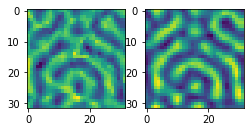

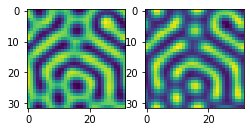

In [59]:
start = 319
plt.subplot(131)
plt.imshow(a_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(s_2[(start*N):((start+1)*N), :].reshape((x_size,y_size)))
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, start].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, start].reshape((x_size,y_size)))
plt.show()

#plt.subplot(131)
#plt.imshow(data[0, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.subplot(132)
#plt.imshow(data[1, :, :, -T_2+start].reshape((x_size,y_size)))
#plt.show()

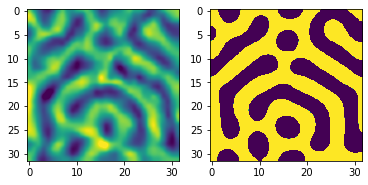

In [60]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)), interpolation='gaussian')

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)), interpolation='gaussian')
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_sparse_noise.gif', writer='imagemagick')

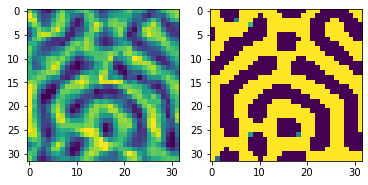

In [61]:
from matplotlib.animation import FuncAnimation

fig, (ax1, ax2) = plt.subplots(1,2)

im1 = ax1.imshow(a_2[0:N, :].reshape((x_size,y_size)))

im2 = ax2.imshow(data[0, :, :, 0].reshape((x_size,y_size)))
ims = [im1, im2]

def init():    
    return ims
    
def animate(i):    
    a=im1.get_array()
    a=a_2[(i*N):((i+1)*N), :].reshape((x_size,y_size))
    im1.set_array(a)
    
    a=im2.get_array()
    a=data[0, :, :, i].reshape((x_size,y_size))
    im2.set_array(a)
    
    return ims

anim = FuncAnimation(fig, animate, init_func=init,
                               frames=T_2, interval=50, blit=True)


anim.save('turring_sol_sparse_noise_2.gif', writer='imagemagick')

In [143]:
x_2 = L*np.linspace(0,1,x_size)
y_2 = L*np.linspace(0,1,y_size)

X_2,Y_2 = np.meshgrid(x_2, y_2, sparse=False, indexing='ij')
XX_2 = X_2.flatten()# N 
YY_2 = Y_2.flatten()# N 

index = -1
t_test = 80000#t_star[index]#0#5000000


TT_2 = np.array([t_test]*N) # N

x_2 = XX_2[:, np.newaxis] # N x 1
y_2 = YY_2[:, np.newaxis] # N x 1
t_2 = TT_2[:, np.newaxis] # N x 1

In [144]:
a_2, s_2 = model.predict(x_2, y_2, t_2)
#a_2, s_2 = model.predict(x, y, t)
a_2 = a_2.reshape((x_size,y_size))
s_2 = s_2.reshape((x_size,y_size))
#c = np.stack((a_2, s_2), axis=0)
#c = c[:, np.newaxis]
#a_2_interp, s_2_interp = rdsolver.viz.interpolate_concs(c)
tf_dict = {model.x_tf: x_2, model.y_tf: y_2, model.t_tf: t_2, 
           model.a_tf:data[0, :, :, index].flatten()[:, np.newaxis],
           model.s_tf:data[1, :, :, index].flatten()[:, np.newaxis],
           model.x_f_tf: x_2, model.y_f_tf: y_2, model.t_f_tf: t_2}
print( f"Loss_a : {model.sess.run(model.loss_a, tf_dict):.8f}")
print( f"Loss_s : {model.sess.run(model.loss_s, tf_dict):.8f}")
print( f"Loss   : {model.sess.run(model.loss, tf_dict):.8f}")

Loss_a : 0.00110971
Loss_s : 0.04844390
Loss   : 195.38664246


In [145]:
print(np.sum(np.power(a_2 - data[0, :, :, index],2)))
print(np.sum(np.power(s_2 - data[1, :, :, index],2)))

179.75139573725164
15.536119960748401


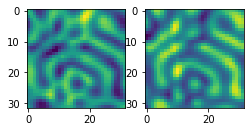

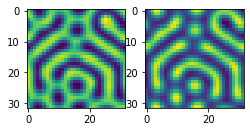

In [146]:

plt.subplot(131)
plt.imshow(a_2)
plt.subplot(132)
plt.imshow(s_2)
plt.show()

plt.subplot(131)
plt.imshow(data[0, :, :, index].reshape((x_size,y_size)))
plt.subplot(132)
plt.imshow(data[1, :, :, index].reshape((x_size,y_size)))
plt.show()

In [125]:
saver = tf.train.Saver()
saver.save(model.sess, './PINN_Turring_model_loss_sampled_random', global_step=0)

'./PINN_Turring_model_loss_sampled_random-0'

In [126]:
print(model.x_tf.name)
print(model.y_tf.name)
print(model.t_tf.name)
print(model.a_pred.name)
print(model.s_pred.name)
print(model.loss_1.name)
print(model.loss_a.name)
print(model.loss_s.name)

x_tf_2:0
y_tf_2:0
t_tf_2:0
a_pred_3:0
s_pred_3:0
add_68:0
loss_a_2:0
loss_s_2:0
